In [51]:
# Importing all relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import pystan
import pandas as pd
import math
import datetime
from sklearn.metrics import mean_squared_error
import pandas
import seaborn


In [52]:
# Importing the Dataset
# There is a slight change that I am making to the dataset wnich is I added a 
# row at the start which said Date for the dates and Amp for CO2 Amount of CO2 Ppm
# This was done to index and call data more easily
dta = pd.read_csv('/content/weekly_in_situ_co2_mlo.csv')

In [53]:
dta.head()

,Date,Amp
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


In [54]:
# Changing the data to a workable format
dta['Date'] = pd.to_datetime(dta['Date'])

In [55]:
dta['Amp']

0       316.19
1       317.31
2       317.69
3       317.58
4       316.48
         ...  
3205    414.84
3206    415.46
3207    415.68
3208    416.91
3209    416.45
Name: Amp, Length: 3210, dtype: float64

In [56]:
# Checking where 2010's first value lies
dta.loc[2632:, ["Date"]]

,Date
2632,2010-01-02
2633,2010-01-09
2634,2010-01-16
2635,2010-01-23
2636,2010-01-30
...,...
3205,2021-01-16
3206,2021-01-23
3207,2021-01-30
3208,2021-02-06


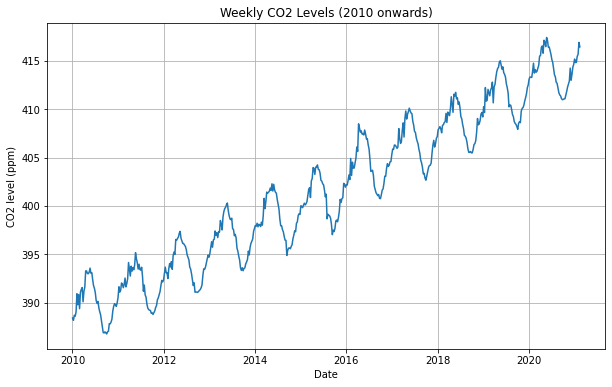

In [57]:
#Let's zoom into a subsection of the data and see what it looks like

x= dta.loc[2632:, ["Date"]]
y = dta.loc[2632:, ['Amp']]

#Plotting figure from instructions 
fig1 = plt.figure(figsize=(10,6))
plt.plot(x,y)
plt.grid()
plt.title('Weekly CO2 Levels (2010 onwards)')
plt.xlabel("Date")
plt.ylabel('CO2 level (ppm)')
plt.show()

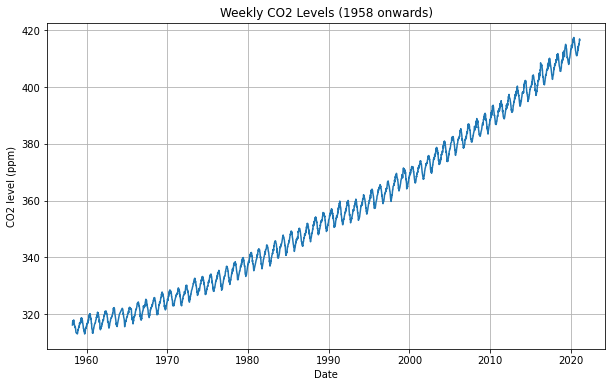

In [58]:
# now let's look at the entire dataset
x1 = dta.Date
y1 = dta.Amp

#Plotting figure from instructions 
fig1 = plt.figure(figsize=(10,6))
plt.plot(x1,y1)
plt.grid()
plt.title('Weekly CO2 Levels (1958 onwards)')
plt.xlabel("Date")
plt.ylabel('CO2 level (ppm)')
plt.show()

In [59]:
# quantifying a week so that we can use that as a reference point in the data
(dta.Date[1] - dta.Date[0]).days / 365.25

0.019164955509924708

In [60]:
# adding a column of time translated in weeks for our Stan model
# This will help us keep track of our model and apply the same date distribution across all datapoints
dta['Time_Progression'] = [(dta.Date[i] - dta.Date[0]).days / 365.25 for i in range(len(dta.Date))]

dta.head()

,Date,Amp,Time_Progression
0,1958-03-29,316.19,0.000000
1,1958-04-05,317.31,0.019165
2,1958-04-12,317.69,0.038330
3,1958-04-19,317.58,0.057495
4,1958-04-26,316.48,0.076660


## Linear Model


In [61]:
dta.Amp.values

array([316.19, 317.31, 317.69, ..., 415.68, 416.91, 416.45])

In [62]:
stan_data = {
    "len_data" : len(dta),
    "date" : dta.Time_Progression.values,
    "co2" : dta.Amp.values,
}

In [63]:
linear_stan_code = """
data {
    int<lower=0> len_data;             // length of data
    real<lower=0> date[len_data];      // time of measurement
    real co2[len_data];               // co2 data
}

parameters {
    real<lower=0> c;  // y intercept
    real<lower=0> m;  // gradient
    real<lower=0> vari;        // noise parameter 
} 

model {
 
    // Priors
    c ~ normal(300, 15);      // selecting this as thats where it starts
    m ~ normal(1,1.5);    // Not a lot of info, so an estimate
    vari ~ cauchy(10,5);    // leaving room for some improvement
 
    for (i in 1:len_data) {
        co2[i] ~ normal(m*date[i]+c, vari); 
    }
}

"""
linear = pystan.StanModel(model_code=linear_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_de34e9a46a9283ae4e3eff8293c4c19f NOW.


In [64]:
#Extract our results through sampling 
linear_results = linear.sampling(data=stan_data)
linear_samples = linear_results.extract()

In [65]:
result_linear = linear.sampling(data = stan_data)
print(result_linear.stansummary())

Inference for Stan model: anon_model_de34e9a46a9283ae4e3eff8293c4c19f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c    305.64  3.4e-3   0.16 305.33 305.54 305.64 305.75 305.95   2055    1.0
m      1.59  9.7e-5 4.3e-3   1.58   1.59   1.59    1.6    1.6   1947    1.0
vari   4.47  1.6e-3   0.06   4.37   4.43   4.47   4.51   4.58   1257    1.0
lp__  -6404    0.04   1.23  -6407  -6404  -6403  -6403  -6402   1194    1.0

Samples were drawn using NUTS at Thu Apr 22 23:27:01 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [66]:
# Code taken from class exercises and PCW
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))
    
def acf_plots(samples,parameters):
    for param in parameters:
        plt.figure(figsize=(10, 3))
        plot_acf(samples[param])
        plt.title('Autocorrelation of '+ str(param) +' samples')
    plt.show()

def pair_plots(samples,parameters):
    df = pd.DataFrame(
        data=np.transpose([samples[param] for param in parameters]),
        columns=parameters)
    seaborn.pairplot(df, size=3.5, plot_kws={'marker': '.', 'alpha': 0.25})
    plt.show()

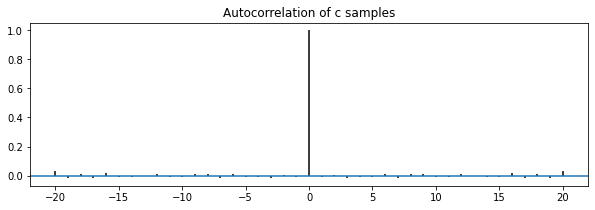

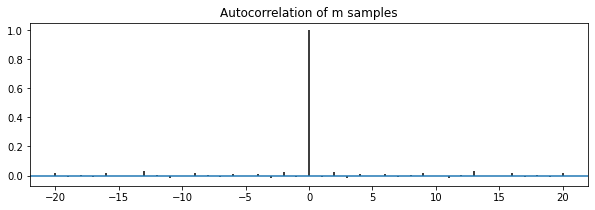

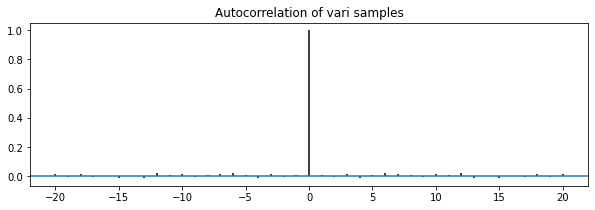

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


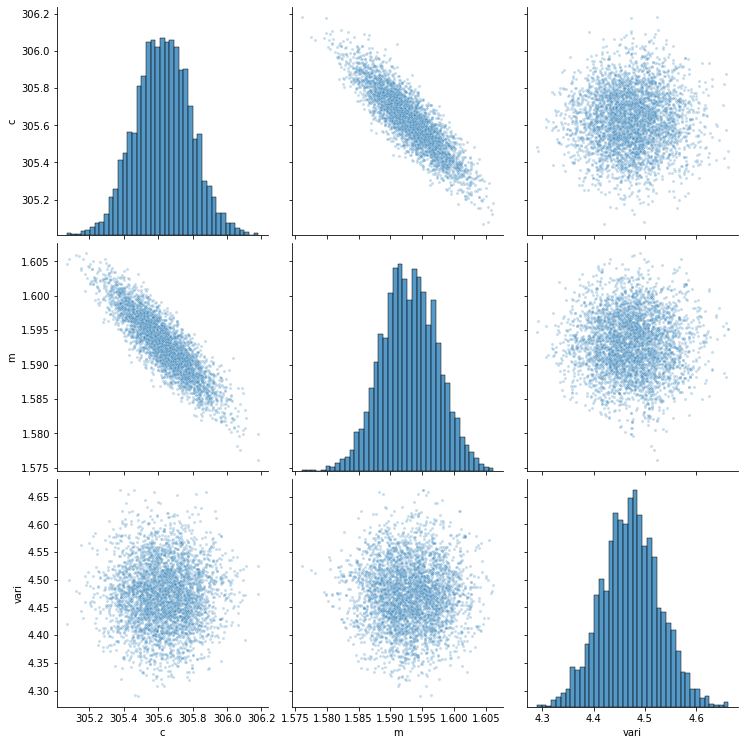

In [67]:
linear_params = ['c', 'm', 'vari']
acf_plots(linear_samples,linear_params)
pair_plots(linear_samples, linear_params)

In [68]:
# Linear line of best fit
# using y = mx + c

c = linear_samples['c'].mean()
m = linear_samples['m'].mean()

linear_approx =m*dta.Time_Progression.values + c

Text(0, 0.5, 'CO2 PPM')

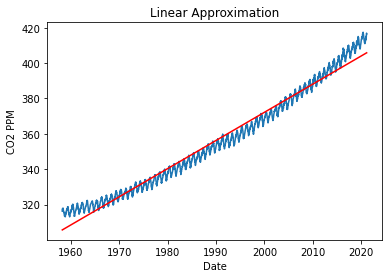

In [69]:
plt.plot(x1,y1)
plt.plot(dta.Date,linear_approx, 'Red')
plt.title('Linear Approximation')
plt.xlabel("Date")
plt.ylabel('CO2 PPM')

## Quadratic Approximation

In [70]:
quadratic_stan_code = """
data {
    int<lower=0> len_data;             // length of data
    real<lower=0> date[len_data];      // time of measurement
    real co2[len_data];               // CO2 data
}

parameters {
    real<lower=0> c;  // y intercept
    real<lower=0> a;  // ax^2
    real<lower=0> b;  // bx
    real<lower=0> vari;        // noise parameter
} 

model {
 
    // Priors
    c ~ normal(300, 30);       // again, similar reasons
    a ~ normal(1,1);          // less info, so leaving room for likelihood
    b ~ normal(0,5);          // same as above
    vari ~ cauchy(10,5);      // still leaving room for variance

    for (i in 1:len_data) {
        co2[i] ~ normal(a*date[i]^2+b*date[i]+c, vari); 
    }
}

"""
quadratic = pystan.StanModel(model_code=quadratic_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_39167c139a0d23dde17bb67cfaceddba NOW.


In [71]:
quadratic_results = quadratic.sampling(data=stan_data)
quadratic_samples = quadratic_results.extract()

In [72]:
result_quadratic = quadratic.sampling(data = stan_data)
print(result_quadratic.stansummary())

Inference for Stan model: anon_model_39167c139a0d23dde17bb67cfaceddba.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c    314.69  3.4e-3   0.12 314.46 314.61 314.69 314.78 314.94   1298    1.0
a      0.01  3.8e-6 1.3e-4   0.01   0.01   0.01   0.01   0.01   1217    1.0
b      0.75  2.5e-4 8.6e-3   0.74   0.75   0.75   0.76   0.77   1149    1.0
vari   2.25  7.3e-4   0.03   2.19   2.23   2.25   2.26    2.3   1455    1.0
lp__  -4203    0.04   1.36  -4206  -4204  -4203  -4202  -4201   1105    1.0

Samples were drawn using NUTS at Thu Apr 22 23:32:41 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


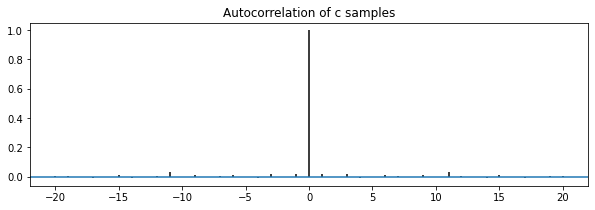

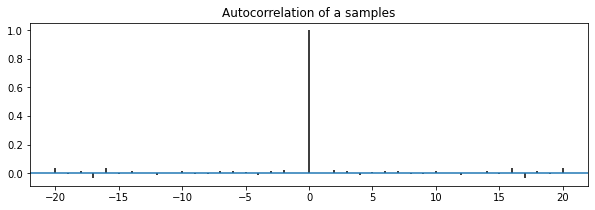

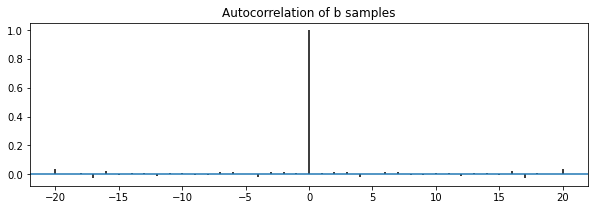

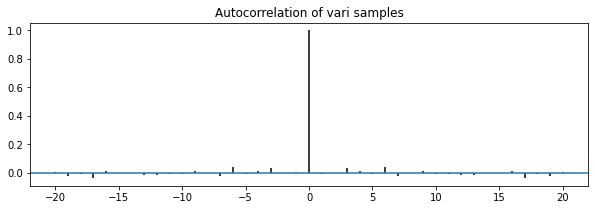

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


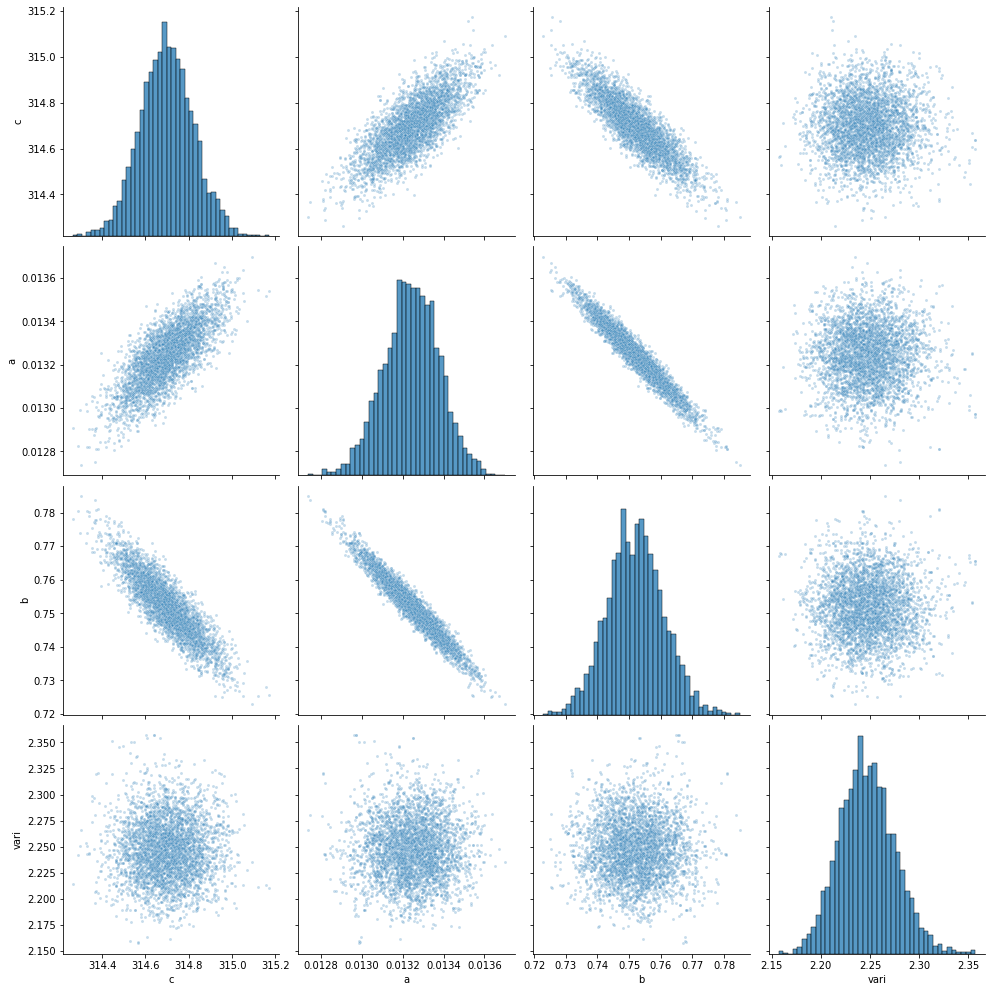

In [73]:
quadratic_params = ['c', 'a', 'b', 'vari']
acf_plots(quadratic_samples, quadratic_params)

pair_plots(quadratic_samples, quadratic_params)

In [74]:
a = quadratic_samples['a'].mean()
b = quadratic_samples['b'].mean()
c = quadratic_samples['c'].mean()


# y = ax^2 + bx + c
quadratic_approx = a*dta.Time_Progression.values**2 + b*dta.Time_Progression.values + c

Text(0, 0.5, 'CO$_2$ level (ppm)')

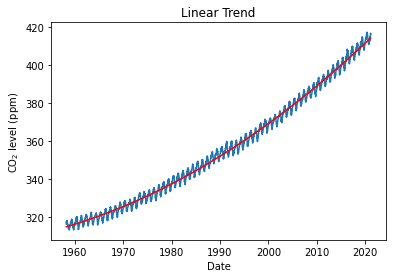

In [75]:
plt.plot(x1,y1)
plt.plot(dta.Date,quadratic_approx, 'Red')
plt.title('Linear Trend')
plt.xlabel("Date")
plt.ylabel(r'CO$_2$ level (ppm)')

## Seasonal Analysis

Text(0, 0.5, 'Variation')

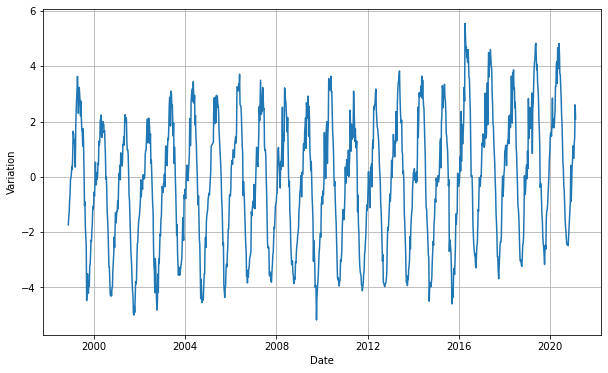

In [76]:
# First we must check the variance of the data from the approximation we did
# I chose the quadratic line since it approximated the upward curve better than the linear one

s1 = dta.Amp - quadratic_approx
plt.figure(figsize = (10,6))
plt.plot(dta.Date[2061:], s1[2061:])
plt.grid()
plt.xlabel('Date')
plt.ylabel('Variation')

In [77]:
# adding a column of seasonal variation
dta['Seasonal'] = dta.Amp - quadratic_approx


s1_data = {
    "len_data" : len(dta),
    "date" : dta.Time_Progression.values,
    "co2" : dta.Seasonal.values,
    "t_pi" : 2*np.pi
}

dta['Seasonal'][20]

-1.1991247653366486

In [78]:
# Now we must create a model for the seasonal variance of the data
seasonal_stan_code = """
data {
    int<lower=0> len_data;             // length of data
    real<lower=0> date[len_data];      // time of measurement
    real co2[len_data];               // CO2 levels
    real<lower=0> t_pi;
    
}

parameters {
    real<lower=0> c2;  
    real<lower=0> vari;        // noise parameter in normal

    real x_phase;            // We need two different phases
    real y_phase;           //since we are modeling a trigonometric wave-like distribution

} 


transformed parameters {
    real phi = atan2(x_phase,y_phase) ;   //we use transformed parameters since these will be used in the model but are
                                        //unknown til the values in the param block are given vals
}

model {
 
    // Priors
    x_phase ~ normal(0,0.5);          // A broad assumption, trying to fit it to the wave
    y_phase ~ normal(0,0.5);          // keeping balance
    c2 ~ inv_gamma(6, 1);            // conjugate prior to the normal dist
    vari ~ cauchy(0,2);             // now that we have more prior data, we can minimize variance

    for (i in 1:len_data) {
        co2[i] ~ normal(c2*cos(t_pi*date[i]+phi), vari); 
    }
}

"""
cos_seasonal_model = pystan.StanModel(model_code=seasonal_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f91f0a25ddfaec4d7f8775a71bebbea7 NOW.


In [79]:
stan_seasonal_results = cos_seasonal_model.sampling(data=s1_data)
print(stan_seasonal_results)

Inference for Stan model: anon_model_f91f0a25ddfaec4d7f8775a71bebbea7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c2        2.86  5.8e-4   0.02   2.81   2.84   2.86   2.87   2.91   1862    1.0
vari      0.98  3.0e-4   0.01   0.96   0.97   0.98   0.99   1.01   1639    1.0
x_phase  -0.27  5.6e-3   0.12  -0.55  -0.35  -0.25  -0.17  -0.08    493   1.01
y_phase   0.62    0.01   0.29   0.19    0.4   0.57    0.8   1.25    505   1.01
phi      -0.41  1.3e-4 8.5e-3  -0.43  -0.42  -0.41  -0.41  -0.39   3971    1.0
lp__     -1557    0.06   1.58  -1561  -1558  -1557  -1556  -1555    781   1.01

Samples were drawn using NUTS at Thu Apr 22 23:39:02 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [80]:
#Extract our results through sampling 
cos_seasonal = stan_seasonal_results.extract()




cos_seasonal_line = cos_seasonal['c2'].mean()*np.cos(2*np.pi*dta.Time_Progression.values+cos_seasonal['phi'].mean())
len(cos_seasonal_line)

cos_seasonal_line[2850:]

array([ 2.46272651e+00,  2.61875732e+00,  2.73686137e+00,  2.81532819e+00,
        2.85302136e+00,  2.84939499e+00,  2.80450159e+00,  2.71899134e+00,
        2.59410267e+00,  2.43164430e+00,  2.23396907e+00,  2.00393987e+00,
        1.74488814e+00,  1.46056566e+00,  1.15509020e+00,  8.32885878e-01,
        4.98619092e-01,  1.57130938e-01, -1.86632901e-01, -5.27693786e-01,
       -8.61112223e-01, -1.18205940e+00, -1.48588713e+00, -1.76819515e+00,
       -2.02489487e+00, -2.25226858e+00, -2.44702329e+00, -2.60633841e+00,
       -2.72790663e+00, -2.80996731e+00, -2.85133198e+00, -2.85140157e+00,
       -2.81017507e+00, -2.72824956e+00, -2.60681153e+00, -2.44761976e+00,
       -2.25297976e+00, -2.02571045e+00, -1.76910332e+00, -1.48687474e+00,
       -1.18311215e+00, -8.62214866e-01, -5.28830352e-01, -1.87786928e-01,
        1.55976163e-01,  4.97480293e-01,  8.31779548e-01,  1.15403236e+00,
        1.45957163e+00,  1.74397232e+00,  2.00311552e+00,  2.23324813e+00,
        2.43103721e+00,  

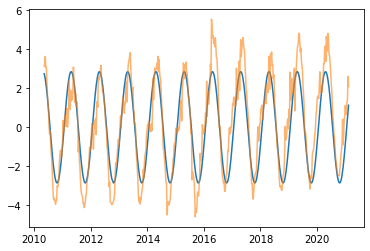

In [81]:
plt.plot(dta.Date[2650:], cos_seasonal_line[2650:])
plt.plot(dta.Date[2650:],dta.Seasonal[2650:],alpha=0.6,label="Real Data")

## Prediction Time

In [82]:
dta.tail()

,Date,Amp,Time_Progression,Seasonal
3205,2021-01-16,414.84,62.803559,0.671849
3206,2021-01-23,415.46,62.822724,1.245550
3207,2021-01-30,415.68,62.841889,1.419240
3208,2021-02-06,416.91,62.861054,2.602921
3209,2021-02-13,416.45,62.880219,2.096593


In [83]:
prediction_dates = pd.date_range("2021-02-13", "2060-01-01", freq='W-FRI')
prediction_times = (prediction_dates - dta.Date[0]).days / 365.25

In [84]:
prediction_times

Float64Index([ 62.89664613278576,  62.91581108829569,  62.93497604380561,
              62.954140999315534,  62.97330595482546, 62.992470910335385,
              63.011635865845314, 63.030800821355236,  63.04996577686516,
              63.069130732375086,
              ...
              101.57152635181383, 101.59069130732375, 101.60985626283367,
               101.6290212183436, 101.64818617385353, 101.66735112936345,
              101.68651608487338,  101.7056810403833, 101.72484599589322,
              101.74401095140315],
             dtype='float64', length=2028)

In [85]:
stan_data = {
    "len_data" : len(dta),
    "date" : dta.Time_Progression.values,
    "co2" : dta.Amp,
    "t_pi" : 2*np.pi,
    "total_future" : len(prediction_times),
    "future_date" : prediction_times
}


In [86]:
#co2_quadratic = """

final_predictive_stan_code = """
data {
    int<lower=0> len_data;             // length of data
    real<lower=0> date[len_data];      // time of measurement
    real co2[len_data];               // CO2 data
    real<lower=0> t_pi;
    
    int<lower=0> total_future; // total future values to predict
    real<lower=0> future_date[total_future];
}

parameters {

    real<lower=0> a;  // ax^2
    real<lower=0> b; // bx
    real<lower=0> c;  // y-int
    real<lower=0> c2;  
    real<lower=0> vari;        // noise parameter in normal

    // We need a periodic phi
    real x_phase;
    real y_phase;

} 

transformed parameters {
    real phi = atan2(x_phase,y_phase) ;
}

model {
 
    // Priors
    a ~ normal(1,1);
    b ~ normal(0,5);
    c ~ normal(300,15);

    x_phase ~ normal(0,0.5);
    y_phase ~ normal(0,0.5);
    c2 ~ normal(6, 1);
    vari ~ cauchy(0,2);

    for (i in 1:len_data) {
        co2[i] ~ normal(a*date[i]^2 + b*date[i] + c+ c2*cos(t_pi*date[i]+phi), vari); 
    }
}

// Here is where the prediction will happen
generated quantities {
    real x_future[total_future];
    for(i in 1:total_future) {
        x_future[i] = normal_rng(
            a*future_date[i]^2+b*future_date[i]+c+c2*cos(t_pi*future_date[i]+phi), vari
            );
    }
}
"""

final_predictive_model = pystan.StanModel(model_code=final_predictive_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ec892108e75fb796a87d7bdf1e0b807d NOW.


In [87]:
stan_results = final_predictive_model.sampling(data=stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [88]:
stan_results


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_ec892108e75fb796a87d7bdf1e0b807d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a              0.01  1.4e-6 6.0e-5   0.01   0.01   0.01   0.01   0.01   1748    1.0
b              0.75  9.3e-5 3.9e-3   0.74   0.75   0.75   0.75   0.76   1761    1.0
c            314.72  1.2e-3   0.05 314.61 314.68 314.72 314.75 314.82   2252    1.0
c2             2.86  5.1e-4   0.02   2.81   2.84   2.86   2.88   2.91   2288    1.0
vari           0.98  2.6e-4   0.01   0.96   0.97   0.98   0.99   1.01   2280    1.0
periodic_x    -0.27  4.5e-3   0.12  -0.55  -0.35  -0.25  -0.17  -0.07    777    1.0
periodic_y     0.61    0.01   0.29   0.16   0.39   0.58   0.79   1.25    778   1.01
phi           -0.41  1.4e-4 8.9e-3  -0.43  -0.42  -0.41  -0.41  -0.39   4089    1.0
x_future[1]  41

In [89]:
samples = stan_results.extract()

In [90]:
a = samples['a'].mean()
b = samples['b'].mean()
c = samples['c'].mean()
c2 = samples['c2'].mean()
phi = samples['phi'].mean()

In [91]:
predic = a*dta.Time_Progression.values**2 + b*dta.Time_Progression.values + c +c2 * np.cos((2 *np.pi *dta.Time_Progression.values)+phi)

In [92]:
predic

array([317.3389449 , 317.47165262, 317.56468652, ..., 414.77530178,
       415.15705655, 415.52710869])

Text(0.5, 1.0, 'CO2 levels from 1958')

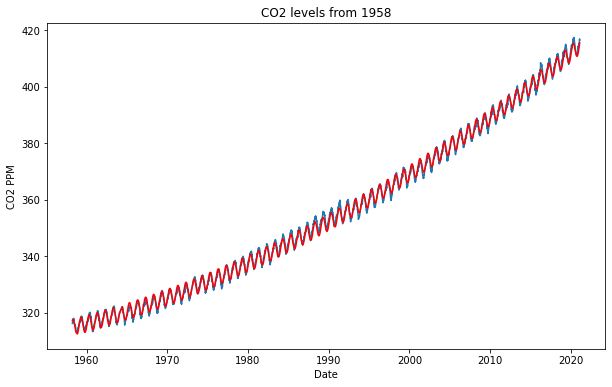

In [109]:
plt.figure(figsize=(10,6))
plt.plot(dta.Date, dta.Amp)
plt.plot(dta.Date, predic, color='red')
plt.xlabel('Date')
plt.ylabel('CO2 PPM')
plt.title('CO2 levels from 1958')


Text(0.5, 1.0, 'CO2 Levels since 2000')

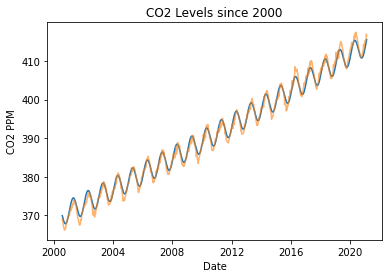

In [94]:
# lets zoom in to get a clearer view

plt.plot(dta.Date[2150:], predic[2150:])
plt.plot(dta.Date[2150:],dta.Amp[2150:],alpha=0.6,label="Real Data")
plt.xlabel('Date')
plt.ylabel('CO2 PPM')
plt.title('CO2 Levels since 2000')

In [95]:
len(predic)

3210

In [96]:
#get the mean predictions from our samples
predictions = []
for i in range(2028):
  sum1 = 0
  for j in range(1000):
    sum1+= samples['x_future'][j][i]
  predictions.append(sum1/1000)

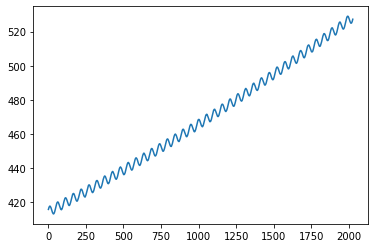

In [97]:
plt.plot(predictions)

In [99]:
lower = []
upper = []
for i in range(2028):
  temp = []
  for j in range(1000):
    temp.append(samples['x_future'][j][i])
  lower.append(np.percentile(temp, 2.5))
  upper.append(np.percentile(temp, 97.5))

In [100]:
len(prediction_dates)
len(predictions)

2028

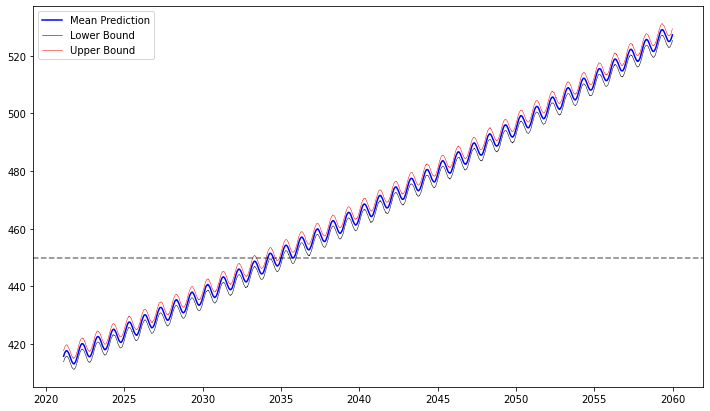

In [101]:
plt.figure(figsize=(12,7))
plt.plot(prediction_dates,predictions, color = 'blue', label = 'Mean Prediction')
plt.plot(prediction_dates,lower, color = 'black', linewidth = 0.5, label = 'Lower Bound')
plt.plot(prediction_dates, upper, color = 'red', linewidth = 0.5, label = 'Upper Bound')
plt.legend()
plt.axhline(450, color = 'black',alpha=0.5,ls='dashed')


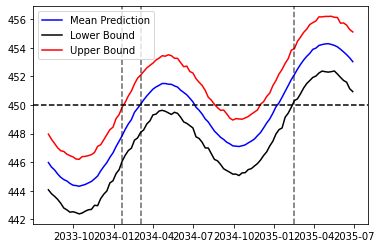

In [102]:
plt.plot(prediction_dates[650:750],predictions[650:750], color = 'blue', label = 'Mean Prediction')
plt.plot(prediction_dates[650:750],lower[650:750], color = 'black', label = 'Lower Bound')
plt.plot(prediction_dates[650:750], upper[650:750], color = 'red', label ='Upper Bound')
plt.legend()
plt.axhline(450, color = 'black', ls = 'dashed')
plt.axvline(prediction_dates[730], color = 'black', ls='dashed', alpha = 0.6)
plt.axvline(prediction_dates[680], color = 'black', ls='dashed', alpha = 0.6)
plt.axvline(prediction_dates[674], color = 'black', ls='dashed', alpha = 0.6)

In [116]:
print('450 ppm is predicted to be reached by:',prediction_dates[680], 'with a 95% confidence interval between',prediction_dates[674],'and',prediction_dates[730])

print('In 2060, the expected PPM is:', predictions[2027], 'With a 95% confidence interval between', lower[2027], 'and', upper[2027])

450 ppm is predicted to be reached by: 2034-03-03 00:00:00 with a 95% confidence interval between 2034-01-20 00:00:00 and 2035-02-16 00:00:00
In 2060, the expected PPM is: 527.2653144396608 With a 95% confidence interval between 525.3367163250434 and 529.3513183367469


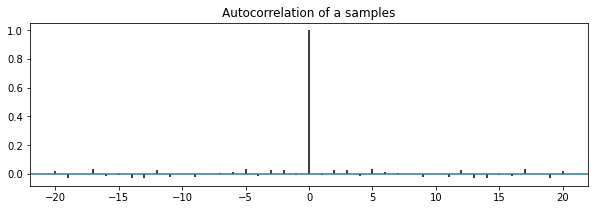

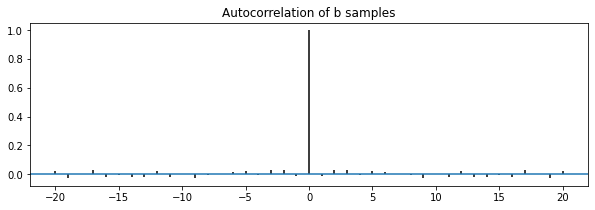

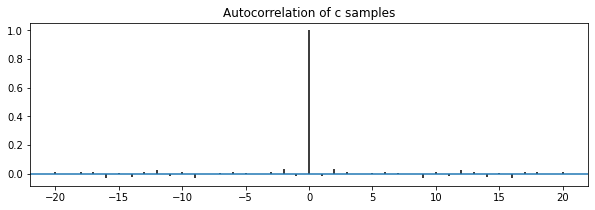

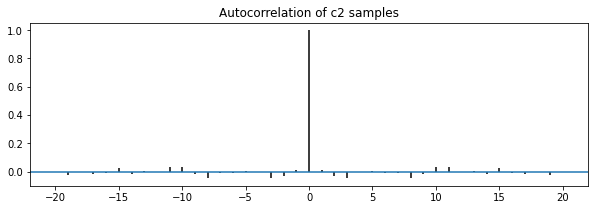

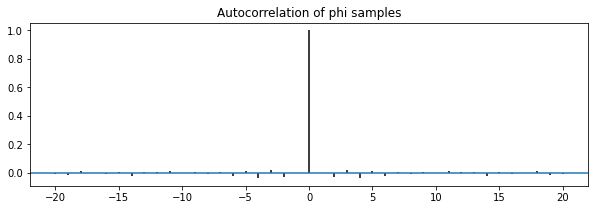

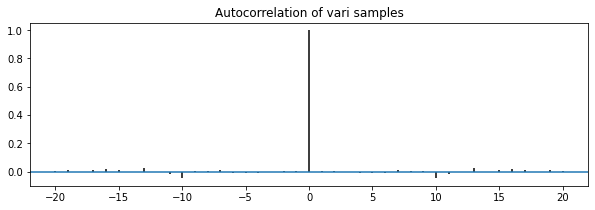

In [104]:
predic_params = ['a','b','c','c2', 'phi','vari']
acf_plots(samples,predic_params)


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


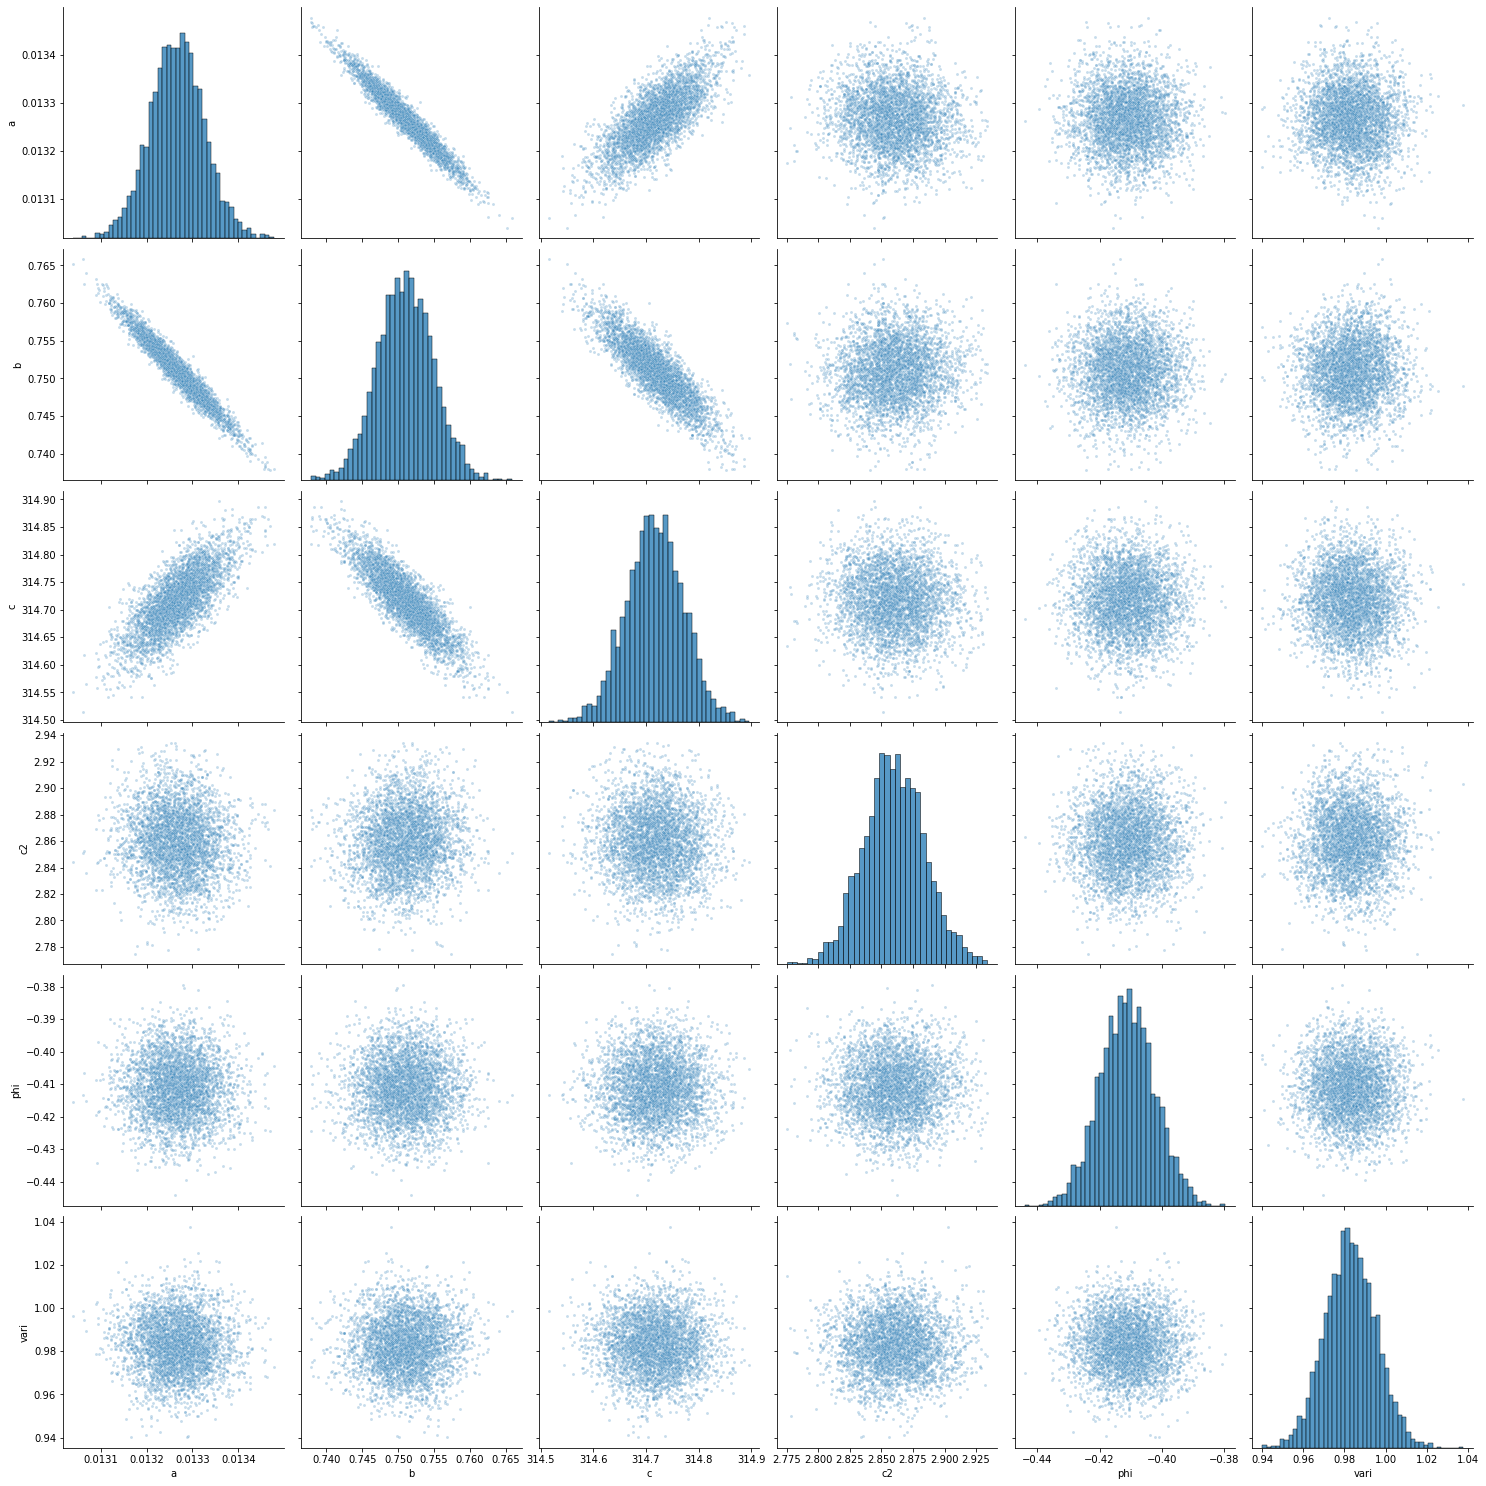

In [105]:
pair_plots(samples, predic_params)

## Test Statistics

In [106]:
#a*dta.Time_Progression.values**2 + b*dta.Time_Progression.values + c +c2 * np.cos((2 *np.pi *dta.Time_Progression.values)+phi)
generated = [ [] for i in range(4000) ]
def gen_samples(store, samples):    
    for i in range(4000):        
        for t in dta['Time_Progression']:
            store[i].append(sts.norm.rvs(samples['a'][i]*t**2 + samples['b'][i]*t + samples['c'][i] + \
                                 samples['c2'][i]*np.cos(2*np.pi*t + samples['phi'][i])  \
                                 , samples['vari'][i]))
    return generated

In [117]:
generated_samples = gen_samples(generated, samples)

In [ ]:
len(generated_samples[0])==len(dta.Date)

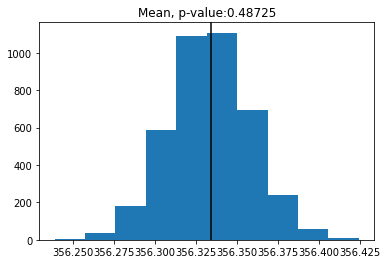

In [118]:
#mean
mean_test = []
count = 0
for i in range(len(generated_samples)):
  mean_test.append(np.mean(generated_samples[i]))
  if np.mean(generated_samples[i]) > np.mean(dta.Amp):
    count += 1
mean_p= count/len(generated_samples)

plt.hist(mean_test)
plt.title('Mean, p-value:'+str(mean_p))
plt.axvline(np.mean(dta.Amp), color='black')

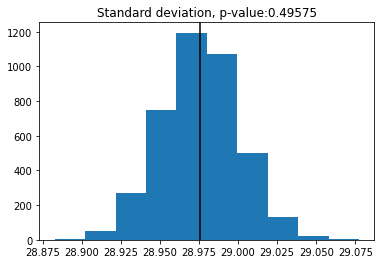

In [119]:
#standard deviation
stand_dev = []
count = 0
for i in range(len(generated_samples)):
  stand_dev.append(np.std(generated_samples[i]))
  if np.std(generated_samples[i]) > np.std(dta.Amp):
    count += 1
sd_p= count/len(generated_samples)

plt.hist(stand_dev)
plt.title('Standard deviation, p-value:'+str(sd_p))
plt.axvline(np.std(dta.Amp), color='black')

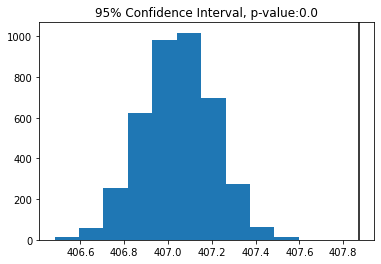

In [120]:
# Confidence Interval
confint_test = []
count = 0
for i in range(len(generated_samples)):
  confint_test.append(np.percentile(generated_samples[i], 95))
  if np.percentile(generated_samples[i], 95) > np.percentile(dta.Amp, 95):
    count += 1
c95_p= count/len(generated_samples)

plt.hist(confint_test)
plt.title('95% Confidence Interval, p-value:'+str(c95_p))
plt.axvline(np.percentile(dta.Amp, 95), color='black')

In [121]:
len(dta)

3210